# Some Synthetic Experiments
This notebook implement the uncertainty quantification method from the paper "Inference and uncertainty quantification for noisy matrix completion" https://arxiv.org/abs/2107.12365


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append('../cmc')

In [2]:
import numpy as np   
import pandas as pd
import pdb
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import logging

#### The functions created for our project

In [3]:
from utils import *     # contains some useful helper functions 
from models import *    # toy models
from solvers import *   # matrix completion solvers
from inference_function import *   # constructing the confidence intervals using the algorithm from the paper
from conformalize_chen import *

## Data generation in original paper

In [4]:
# Data generating functions
def generate_fixed_matrix(n1, n2, r, kappa=1):
    U_truth = orth(np.random.randn(n1, r))
    V_truth = orth(np.random.randn(n2, r))
    S_truth = np.diag(np.linspace(1, kappa, r))
    M = U_truth @ S_truth @ V_truth.T
    M = M / np.std(M)
    return M

def generate_noise(n1, n2, sigma, df="inf"):
    if df=="inf":
        E = np.random.normal(0, sigma, (n1, n2))
    else:
        E = sigma * np.random.standard_t(df, (n1, n2))
    return E

# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4
sigma = 1
kappa = 1
np.random.seed(1)



M = generate_fixed_matrix(n1, n2, r, kappa=kappa)  # M is rescaled with std(M)=1
E = generate_noise(n1, n2, sigma)

A = (np.random.rand(n1, n2) < p).astype(int)
M_obs = (M + E) * A

## Run the confidence interval constructed by the inference paper (Chen et al.)

In [5]:
alpha = 0.1

### Nonconvex method

In [6]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='ncvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.834
Average CI Length: 1.6821981694125852


### Convex Method

In [7]:
CI_left, CI_right = CI_method(M_obs, A, r, alpha, method='cvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.8305
Average CI Length: 1.680930255017741


# Plot the average coverage

## Experiment with fixed ground matrix and resampled masks
The ground truth noisy matrix is kept same for all repetition and the mask matrix is resampled at each iteration.

### Nonconvex method

In [8]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [9]:
repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=mask, r=r, alpha=alpha, 
                                                    method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 17.49it/s]


#### Plot the average coverage and the length of confidence intervals

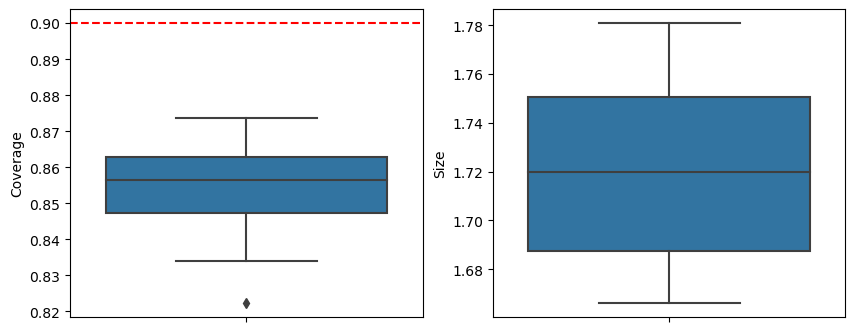

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## Experiments with everything resampled every iteration

### Use a different rank for matrix completion (nonconvex)

In [11]:
# Data generation
n1 = 100
n2 = 100
r_true = 5
r_guess = 4
p = 0.4 #proportion of observed
sigma = 0.001
kappa = 1

In [12]:
#nonconvex method
repetition = 100
alpha = 0.1
random_state = 42

results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, method='ncvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 100/100 [00:07<00:00, 13.13it/s]


In [13]:
# Convex method
results = []

for i in tqdm(range(repetition)):
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)
    
    M_true = M + E
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, method='cvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df_cvx = pd.DataFrame(results)

100%|██████████| 100/100 [00:32<00:00,  3.11it/s]


Nonconvex


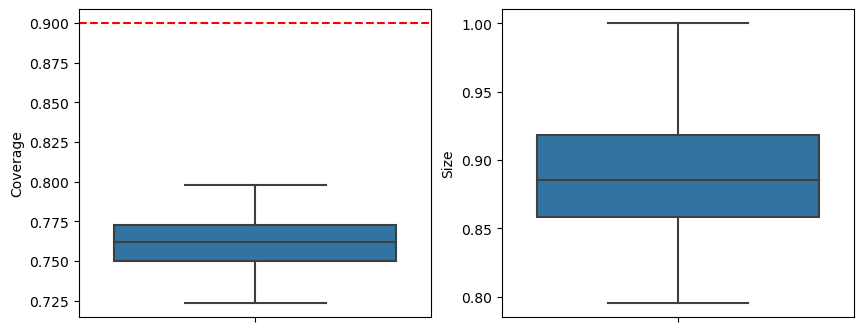



Convex


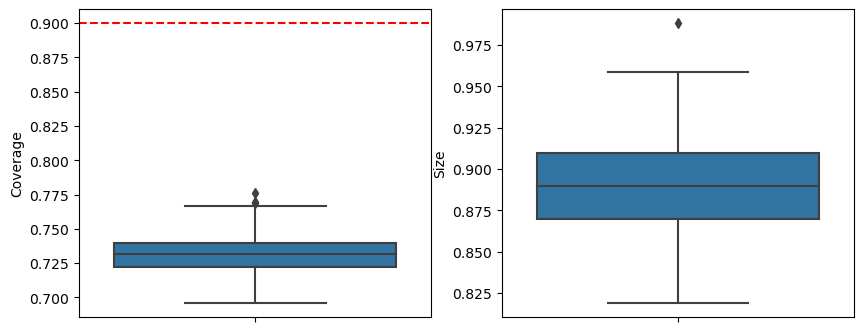

In [14]:
print('Nonconvex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

print('\n'+'='*70+'\n')
print('Convex')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df_cvx, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df_cvx, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

# Experiments with varying matrix sizes

In [15]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100,200,300]

def run_experiment(n, seed, method = 'ncvx'):
    # default method is nonconvex
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method=method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 10
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        res_new = run_experiment(n, seed, method = 'cvx')
        results = pd.concat([results, res_new])

100%|██████████| 10/10 [00:01<00:00,  6.06it/s]


In [16]:
summary = results.groupby(['n']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  Seed  Coverage                Size          
       count      mean       std      mean       std
0  100    10  0.848060  0.009652  1.442049  0.022408
1  200    10  0.867465  0.004357  1.003189  0.005365
2  300    10  0.877639  0.005707  0.823680  0.001902

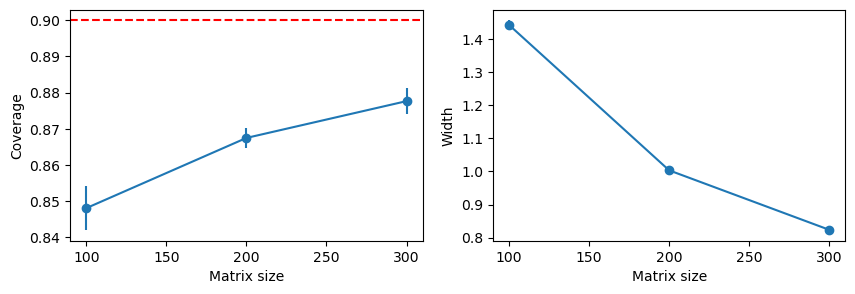

In [17]:
plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["n"], summary["Coverage"]["mean"])
plt.errorbar(summary["n"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["n"], summary["Size"]["mean"])
plt.errorbar(summary["n"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Matrix size")
plt.ylabel("Width")

plt.show()

# Experiments with non-Gaussian noise (heavy tail)

In [18]:
# Fixed parameters
r_true = 5
r_guess = 5
p = 0.5        #proportion of observed
sigma = 1
kappa = 1
alpha = 0.1

# Varying parameters
n_list = [100]
df_list = [2,3,4,5,10]

def run_experiment(n, df, seed, method = 'ncvx'):
    # Parameters for this experiment
    n1 = n
    n2 = n
    
    #regenerate the underlying matrix
    M = generate_fixed_matrix(n1, n2, r_true, kappa=kappa)
    #regenerate the noise matrix
    E = generate_noise(n1, n2, sigma, df=df)
    M_true = M + E

    # regenerate mask
    A = (np.random.rand(n1, n2) < p).astype(int)    
    
    # run the inference algorithm
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_true, mask=A, r=r_guess, alpha=alpha, 
                                                    method = method)
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    res = pd.DataFrame({"n":[n], "df":[df], "Seed":[seed], "Coverage": [result_coverage], "Size": [result_length]})
    return res

repetition = 100
results = pd.DataFrame({})
for seed in tqdm(range(repetition)):
    for n in n_list:
        for df in df_list:
            res_new = run_experiment(n, df, seed, method = 'cvx')
            results = pd.concat([results, res_new])

100%|██████████| 100/100 [00:47<00:00,  2.08it/s]


In [19]:
summary = results.groupby(['n','df']).agg({'Seed':['count'],'Coverage':[np.mean,np.std], 'Size':[np.mean,np.std]}).reset_index()
summary

n  df  Seed  Coverage                Size          
           count      mean       std      mean       std
0  100   2   100  0.699165  0.078828  3.893615  2.398838
1  100   3   100  0.781854  0.033883  2.319869  0.140055
2  100   4   100  0.812844  0.012544  1.949884  0.089043
3  100   5   100  0.821602  0.013016  1.782323  0.040008
4  100  10   100  0.835917  0.010110  1.575884  0.020125

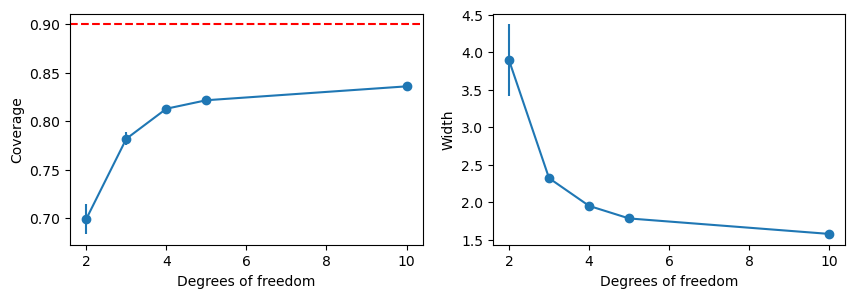

In [20]:
summary = summary[summary['n'] == 100] 

plt.rcParams["figure.figsize"] = (10,3)

plt.subplot(1, 2, 1)
plt.scatter(summary["df"], summary["Coverage"]["mean"])
plt.errorbar(summary["df"], summary["Coverage"]["mean"], 2*summary["Coverage"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.axhline(y=1-alpha, color='r', linestyle='--')
plt.xlabel("Degrees of freedom")
plt.ylabel("Coverage")

plt.subplot(1, 2, 2)
plt.scatter(summary["df"], summary["Size"]["mean"])
plt.errorbar(summary["df"], summary["Size"]["mean"], 2*summary["Size"]["std"]/np.sqrt(summary["Seed"]["count"]))
plt.xlabel("Degrees of freedom")
plt.ylabel("Width")

plt.show()

## Implementing with our data generating functions

Sampling from the noisy random orthogonal model... 



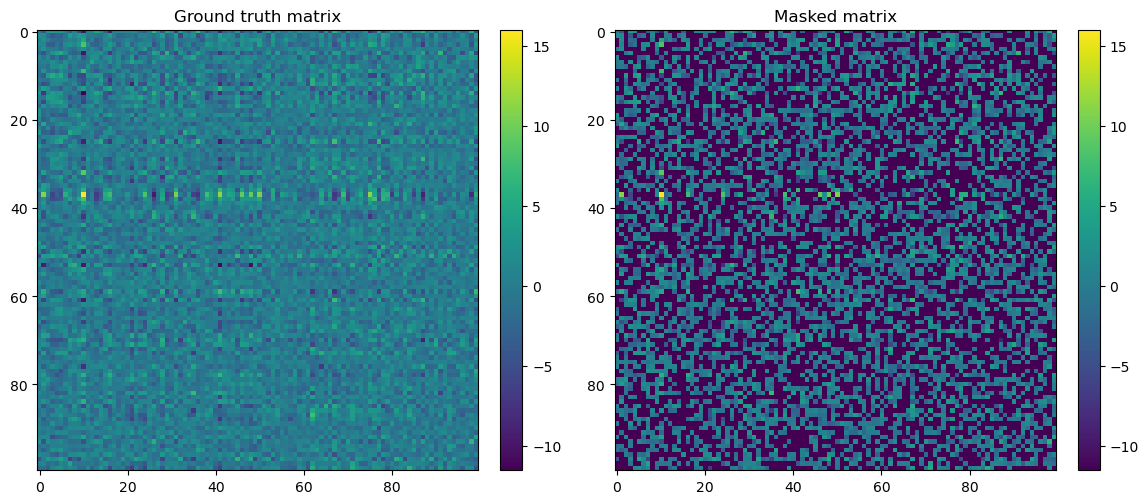

In [21]:
# Define experiment parameters
m, n, r = 100,100, 5
prob_obs = 0.5
random_state = 1
sigma = 1  #noise level

# Generate missing samples
sampler = RandomSampling(m, n)
mask = sampler.sample_observed(prop = prob_obs, fix_size = False, random_state=random_state)

# print('Sampling from the noiseless random factorization model... \n')
# RFM = RandomFactorizationModel(m ,n, r)
# _, _ ,M_rfm = RFM.sample_noiseless(random_state)

# masked_M_rfm = mask * M_rfm
# vmin, vmax = np.min(M_rfm), np.max(M_rfm)
# plot_before_after_mask(M_rfm, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

# print('Sampling from the noiseless random orthogonal model... \n')
# ROM = RandomOrthogonalModel(m ,n, r)
# _,_,M_rom = ROM.sample_noiseless(random_state)

# masked_M_rom = mask * M_rom
# vmin, vmax = np.min(M_rom), np.max(M_rom)
# plot_before_after_mask(M_rom, mask, vmin, vmax)

# print('\n'+'='*70+'\n')

print('Sampling from the noisy random orthogonal model... \n')
ROM = RandomOrthogonalModel(m ,n, r)
_,_,_,M, M_rom_noisy = ROM.sample_noisy(random_state= random_state, sigma=sigma)

masked_M_rom = mask * M_rom_noisy
vmin, vmax = np.min(M_rom_noisy), np.max(M_rom_noisy)
plot_before_after_mask(M_rom_noisy, mask, vmin, vmax)

In [22]:
alpha = 0.1

# The data generating function goes back to the top
CI_left, CI_right = CI_method(M_obs = masked_M_rom, A = mask, r = r, alpha = alpha, method = 'ncvx')

# check
inside_CI = (M < CI_right) & (M > CI_left)
print(np.mean(inside_CI))  # if around (1-alpha), then good

#compute CI length
CI_length = CI_right - CI_left
print("Average CI Length:", CI_length.mean())

0.9452
Average CI Length: 1.9704269742409106


In [23]:
#NOTICE that here M is the matrix without noise

repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    mask = (np.random.rand(n1, n2) < p).astype(int)
    CI_left, CI_right = run_single_experiment_paper(matrix_noisy_unmasked = M_rom_noisy, mask=mask, r=r, alpha=alpha, 
                                                    method='cvx')
    inside_CI = (M < CI_right) & (M > CI_left)
    result_coverage = np.mean(inside_CI)
    
    CI_length = CI_right - CI_left
    result_length = CI_length.mean()
    
    results.append({"Coverage": result_coverage, "Size": result_length})
    
results_df = pd.DataFrame(results)

100%|██████████| 10/10 [00:00<00:00, 19.41it/s]


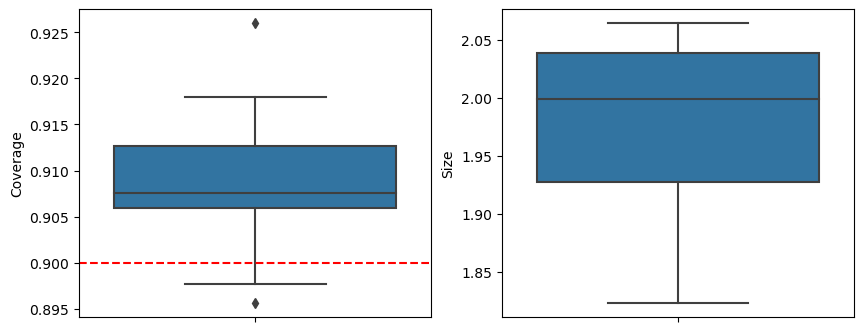

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results_df, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results_df, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## Comformal inference based on this inference method

### Fixed matrices and resampled masks (this part has been changed)

In [25]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [26]:
from conformalize_chen import *

In [27]:
repetition = 10
alpha = 0.1
random_state = 1

results = []

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    calib_size = mask.sum()/2
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results.append({"Quantile": res})

result_df_ = pd.DataFrame(results)



100%|██████████| 10/10 [00:00<00:00, 10.49it/s]


In [28]:
print(result_df_)

                                            Quantile
0     Coverage      Size  Quantile  Conformity_sc...
1     Coverage      Size  Quantile  Conformity_sc...
2     Coverage      Size  Quantile  Conformity_sc...
3     Coverage      Size  Quantile  Conformity_sc...
4     Coverage      Size  Quantile  Conformity_sc...
5     Coverage      Size  Quantile  Conformity_sc...
6     Coverage      Size  Quantile  Conformity_sc...
7     Coverage      Size  Quantile  Conformity_sc...
8     Coverage      Size  Quantile  Conformity_sc...
9     Coverage      Size  Quantile  Conformity_sc...


TypeError: Vertical orientation requires numeric `y` variable.

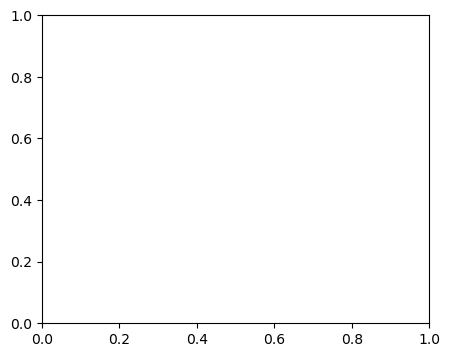

In [29]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(y="Quantile", data=result_df_, ax=ax1)
ax1.set(ylabel='Conformity Score')
ax1.axhline(norm.ppf(1 - alpha/2), ls='--', color="red")


plt.show()

### Changing Marix Size

In [ ]:
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
alpha = 0.1


n_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

results_n = pd.DataFrame({})

for n in n_list:
    n1 = n
    n2 = n
    np.random.seed(n)
    
    M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
    E = generate_noise(n1, n2, sigma)
    M_true = M + E
    repetition = 10
    
    results = []
    
    for i in tqdm(range(repetition)):
        sampler = RandomSampling(n1, n2)
        mask = sampler.sample_observed(prop = p, random_state=i)
        test_mask = np.ones_like(mask) - mask

        #because the code of the class has been changed.
        #now we have to specify the exact size of the calibration set first
        calib_size = mask.sum()/2
        train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                          calib_size=calib_size)

        res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                        M_noiseless= M,
                                                       train_mask=train_mask,
                                                       test_mask=test_mask,
                                                       calib_mask=calib_mask,
                                                       alpha=alpha,
                                                       r_guess = r)

        results.append({"Quantile": res, "n": n})
    result_df_ = pd.DataFrame(results)
    results_n = pd.concat([results_n, result_df_]) 
    
    
    

In [ ]:
results_n

In [ ]:
summary = results_n.groupby(['n']).agg({'Quantile':[np.mean,np.std]}).reset_index()
summary

In [ ]:
plt.rcParams["figure.figsize"] = (5,3)

plt.subplot(1, 1, 1)
plt.scatter(summary["n"], summary["Quantile"]["mean"])
plt.axhline(y=norm.ppf(1 - alpha/2), color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Conformity score")

plt.show()

# This part of code above is not able to re-run because the function has been modified (corrected with flattened matrices)

#### Modified Version and reproduce the plots above

In [30]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [31]:
repetition = 10
alpha = 0.1
random_state = 1

results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    
    # calibration size
    calib_size = 500
    
    
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 10/10 [00:00<00:00, 11.47it/s]


In [32]:
results

,Coverage,Size,Quantile,Conformity_score,Alpha,Seed,Calib_size,Train_size
0,0.915167,2.555633,0.965709,2.116632,0.1,0,500,3500
0,0.896167,2.215627,0.942210,1.897289,0.1,0,500,3500
0,0.891333,2.377027,0.961300,2.067364,0.1,0,500,3500
0,0.902000,2.614897,0.974464,2.233199,0.1,0,500,3500
0,0.906000,2.391665,0.958384,2.037344,0.1,0,500,3500
0,0.891833,2.314829,0.948542,1.947642,0.1,0,500,3500
0,0.891833,2.332717,0.935278,1.847174,0.1,0,500,3500
0,0.894833,2.262279,0.929161,1.806505,0.1,0,500,3500
0,0.908667,2.375507,0.936836,1.858034,0.1,0,500,3500
0,0.907167,2.415538,0.957054,2.024236,0.1,0,500,3500


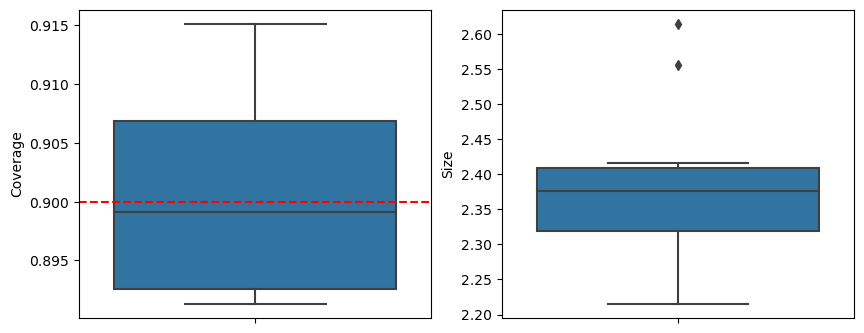

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

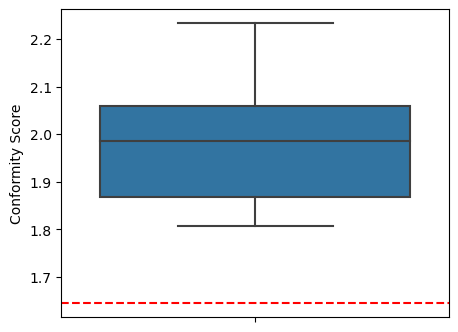

In [34]:
fig, (ax1) = plt.subplots(1, 1, figsize=(5, 4))
sns.boxplot(y="Conformity_score", data=results, ax=ax1)
ax1.set(ylabel='Conformity Score')
ax1.axhline(norm.ppf(1 - alpha/2), ls='--', color="red")


plt.show()

## Now run with different matrix size (200x200) (the above is 100x100)

In [35]:
# Data generation
n1 = 200
n2 = 200
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [36]:
repetition = 10
alpha = 0.1
random_state = 1

results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    calib_size = mask.sum()/2
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 10/10 [00:02<00:00,  3.66it/s]


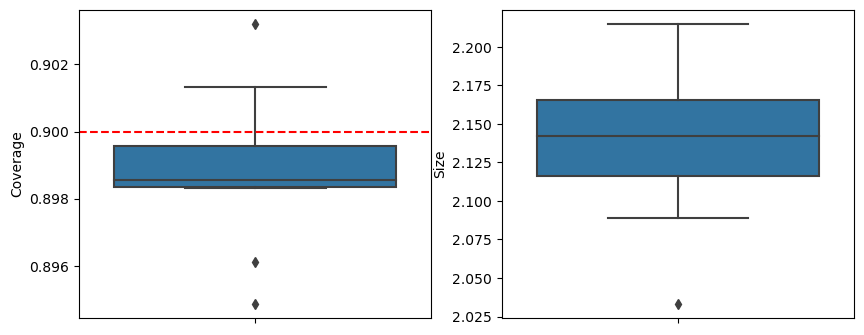

In [37]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

## More repetition?

In [38]:
# Data generation
n1 = 100
n2 = 100
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
np.random.seed(1)

M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
E = generate_noise(n1, n2, sigma)
M_true = M + E

In [39]:
repetition = 1000
alpha = 0.1
random_state = 1

results = pd.DataFrame({})

for i in tqdm(range(repetition)):
    sampler = RandomSampling(n1, n2)
    mask = sampler.sample_observed(prop = p, random_state=i)
    test_mask = np.ones_like(mask) - mask
    
    #because the code of the class has been changed.
    #now we have to specify the exact size of the calibration set first
    calib_size = mask.sum()/2
    train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                      calib_size=calib_size)
    
    res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                    M_noiseless= M,
                                                   train_mask=train_mask,
                                                   test_mask=test_mask,
                                                   calib_mask=calib_mask,
                                                   alpha=alpha,
                                                   r_guess = r)
    
    results = pd.concat([results, res])



100%|██████████| 1000/1000 [01:42<00:00,  9.72it/s]


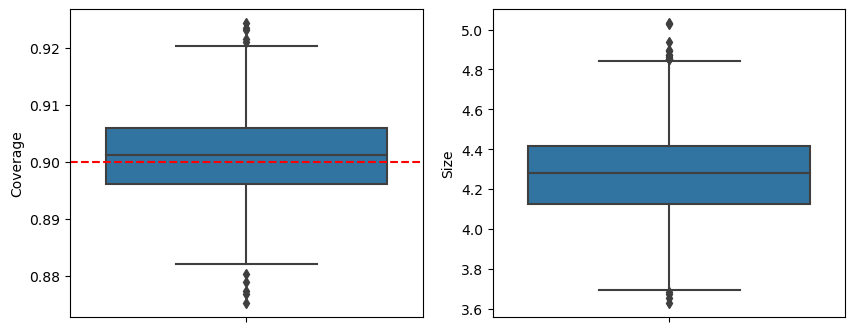

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(y="Coverage", data=results, ax=ax1)
ax1.set(ylabel='Coverage')
ax1.axhline(1 - alpha, ls='--', color="red")

sns.boxplot(y="Size", data=results, ax=ax2)
ax2.set(ylabel='Size')
plt.show()

### Changing Matrix Size

In [42]:
r = 5
p = 0.4 #proportion of observed
sigma = 1  # noise level can be changed (orignally 1e-3)
kappa = 1
alpha = 0.1


n_list = [20, 30, 40, 50, 60, 70, 80, 90, 100]
# n_list = [100, 200, 500]
repetition = 10


results = pd.DataFrame({})

for n in n_list:
    n1 = n
    n2 = n
    np.random.seed(n)
    
    M = generate_fixed_matrix(n1, n2, r, kappa=kappa)
    E = generate_noise(n1, n2, sigma)
    M_true = M + E

    
    for i in tqdm(range(repetition)):
        sampler = RandomSampling(n1, n2)
        mask = sampler.sample_observed(prop = p, random_state=i)
        test_mask = np.ones_like(mask) - mask

        #because the code of the class has been changed.
        #now we have to specify the exact size of the calibration set first
        calib_size = mask.sum()/2
        train_mask,calib_mask = sampler.sample_train_calib(mask=mask, 
                                                          calib_size=calib_size)

        res = run_single_experiment_conformalized_paper(matrix_noisy_unmasked=M_true,
                                                        M_noiseless= M,
                                                       train_mask=train_mask,
                                                       test_mask=test_mask,
                                                       calib_mask=calib_mask,
                                                       alpha=alpha,
                                                       r_guess = r)

        res['n']=[n]
        results = pd.concat([results, res])

100%|██████████| 10/10 [00:00<00:00, 11.04it/s]


In [43]:
results

,Coverage,Size,Quantile,Conformity_score,Alpha,Seed,Calib_size,Train_size,n
0,0.929167,4.554628,0.312890,0.402780,0.1,0,80,80,20
0,0.954167,4.992756,0.280782,0.359504,0.1,0,80,80,20
0,0.925000,4.845577,0.284390,0.364332,0.1,0,80,80,20
0,0.941667,4.447139,0.247767,0.315696,0.1,0,80,80,20
0,0.866667,3.672319,0.249725,0.318276,0.1,0,80,80,20
...,...,...,...,...,...,...,...,...,...
0,0.892500,4.241650,0.888941,1.593453,0.1,0,2000,2000,100
0,0.910667,4.555053,0.893695,1.615026,0.1,0,2000,2000,100
0,0.891833,4.037531,0.869399,1.511736,0.1,0,2000,2000,100
0,0.906833,4.164705,0.859770,1.474934,0.1,0,2000,2000,100


In [44]:
summary_flat = results.groupby(['n']).agg({'Conformity_score':[np.mean,np.std]}).reset_index()
summary_flat

n Conformity_score          
                   mean       std
0   20         0.340058  0.030665
1   30         0.563104  0.058970
2   40         0.769311  0.105948
3   50         1.066369  0.086600
4   60         1.247925  0.077262
5   70         1.425648  0.134511
6   80         1.592209  0.171714
7   90         1.709971  0.166935
8  100         1.629153  0.131856

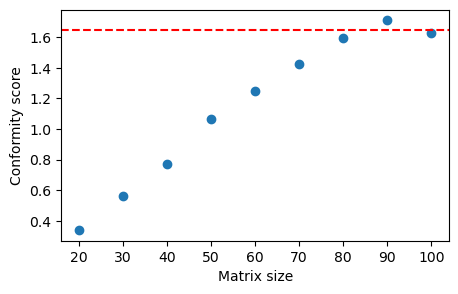

In [45]:
plt.rcParams["figure.figsize"] = (5,3)

plt.subplot(1, 1, 1)
plt.scatter(summary_flat["n"], summary_flat["Conformity_score"]["mean"])
plt.axhline(y=norm.ppf(1 - alpha/2), color='r', linestyle='--')
plt.xlabel("Matrix size")
plt.ylabel("Conformity score")

plt.show()